# Анализ результатов A/B-теста

## Описание проекта

Заказчик - крупный интернет-магазин.

Отделом маркетинга подготовлены гипотезы в файле `hypothesis.csv` с оцененными параметрами Reach, Impact, Confidence, Effort. Каждая из этих гипотез может увеличить выручку магазина. 

Необходимо:
- 1) С помощью фреймворков ICE и RICE приоритизировать гипотезы к тестированию - выбрать первоочередные;
- 2) Запустить A/B-тест и получить результаты, затем провести их анализ и принять решение о дальнейшей судьбе теста. Возможные варианты:
    - Остановка и признание неуспешным (отсутствие различий между группами);
    - Остановка и признание успешным (фиксация победы одной из групп);
    - Продолжение теста (замечен тренд на различие, но данных для принятия решения недостаточно).

In [1]:
# импорт библиотек
import warnings
warnings.filterwarnings("ignore")

import math as mth
import pandas as pd
import numpy as np
from scipy import stats as st

import datetime as dt

import matplotlib.pyplot as plt

In [2]:
# подготовка функции для вывода общей информации о датасете
def data_main_info(data):
    
    # вывод шапки и общей информации
    print('Шапка и общая информация о данных')
    display(data.head(10))
    print(data.info())
    print()
    
    # вывод статистической информации о датасете
    print('Статистическая информация о данных')
    display(data.describe())
    print()
    
    # подсчет и вывод количества явных дубликатов в данных
    print('Количество явных дубликатов в данных:', data.duplicated().sum())
    print()
    
    # подсчет и вывод количества пропусков по столбцам
    print('Количество пропусков в данных')
    display(data.isna().sum().sort_values(ascending=False))

## Изучение данных по гипотезам

### Изучение датасета по гипотезам

Изучим датасет `hypothesis.csv`, который содержит набор гипотез по увеличению выручки, предварительно оцененных по составляющим фреймворков ICE и RICE

In [3]:
# чтение данных по гипотезам
hypothesis = pd.read_csv('/Users/danilvlasenko/Desktop/projects_datasets/hypothesis.csv')

# основная информация о данных по гипотезам
data_main_info(hypothesis)

Шапка и общая информация о данных


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

Статистическая информация о данных


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000



Количество явных дубликатов в данных: 0

Количество пропусков в данных


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

В данных представлено 9 предварительно оцененных гипотез.

Описание столбцов:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Проблемы с данными отсутствуют. Используем датасет `hypothesis` для приоритизации гипотез

### Приоритизация гипотез

Произведем приоритизацию имеющихся 9 гипотез - важно определить первоочередную гипотезу для проверки, которая не сильно сложная для подготовки и оптимальная по трудозатратам команды.

Оценка будет производиться по фреймворкам ICE и RICE - добавим в датасет `hypothesis` новые расчетные столбцы ICE и RICE соответственно.

In [4]:
# приоритизация гипотез по ICE

# расчет ICE
hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']).round(2)

# сортировка по убыванию значения и вывод гипотез
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


In [5]:
# вывод полного текста гипотезы №9
# вывод по индексу - индекс 9-ой гипотезы это 8
print(hypothesis['Hypothesis'][8])

Запустить акцию, дающую скидку на товар в день рождения


Самую высокую оценку получила гипотеза №9. Но это был расчет без учета параметра возможно охвата `Reach`. Посчитаем с его учетом.

In [6]:
# приоритизация гипотез по RICE

# расчет RICE
hypothesis['RICE'] = (((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) 
                      / hypothesis['Efforts'])).round(2)

# сортировка по убыванию значения и вывод гипотез
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


In [7]:
# вывод полной формулировки гипотезы 8
print(hypothesis['Hypothesis'][7])

Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


C учетом охвата, лидирует гипотеза №8.

В A/B-тесте также важна большая выборка респондентов, поэтому с учетом охвата, стоит отдать приоритет и запустить тест именно по гипотезе №8. Добавление формы подписки позволит собрать адреса потенциальных клиентов, а это открывает дополнительные возможности по привлечению уже не совсем "холодных" потециальных клиентов.

Соответственно, в тесте будет 2 группы: у одной будет форма подписки на рассылки, а у другой не будет. Посмотрим, как это будет влиять на выручку и средний чек.

Приступаем к тесту.

## Проведение A/B-теста

A/B-тест проведен, результаты получены.

Информацию по посещению интернет-магазина за период теста имеем в датасете `visitors`, информацию по совершенным покупкам - в датасете `orders`.

### Получение данных теста

В первую очередь, изучим оба файла более подробно.

#### Информация о посещениях

In [8]:
# чтение файла visitors
visitors = pd.read_csv('/Users/danilvlasenko/Desktop/projects_datasets/visitors.csv')

# получение основной информации
data_main_info(visitors)

Шапка и общая информация о данных


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

Статистическая информация о данных


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000



Количество явных дубликатов в данных: 0

Количество пропусков в данных


date        0
group       0
visitors    0
dtype: int64

В данных по посещениям имеем следующие столбцы:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

Пропуски и явные дубликаты в данных отсутствуют. Тип данных в будущем стоит изменить только у `date`

Судя по 62 строкам в датасете и первым 10 значениям шапки (день увеличивается на 1), имеем статистику по 2-м группам за 31 день (полностью август 2019-го). Посмотрим, на всякий случай, минимальное и максимальное имеющиеся значения даты.

In [9]:
print('Начало теста:', visitors['date'].min())
print('Окончание теста:', visitors['date'].max())

Начало теста: 2019-08-01
Окончание теста: 2019-08-31


Действительно, тест гипотезы был проведен в августе 2019-го.

Изменим тип данных в столбце с датой

In [10]:
# приведение даты
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# проверка изменения типа данных в столбце с датой
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


#### Информация о покупках

In [11]:
# чтение файла orders
orders = pd.read_csv('/Users/danilvlasenko/Desktop/projects_datasets/orders.csv')

# получение основной информации
data_main_info(orders)

Шапка и общая информация о данных


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

Статистическая информация о данных


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06



Количество явных дубликатов в данных: 0

Количество пропусков в данных


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

В данных по покупкам имеем следующие столбцы:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Пропуски и явные дубликаты в данных отсутствуют. Тип данных в будущем стоит изменить только у `date`.

За 31 день тестирования, всего было совершено 1197 покупок.

In [12]:
# приведение даты
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# проверка изменения типа данных в столбце с датой
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


#### Общий обзор групп A и B

Перед анализом, еще немного посмотрим на данные.

Как минимум, стоит посмотреть на число попавших под тест в каждой группе. Для этого сгруппипируем по группам данные из датасета `orders`.

In [13]:
# вывод численности групп
orders.groupby('group').agg({'visitorId': 'nunique'})

,visitorId
group,
A,503
B,586


Имеем 503 участника в группе A и 586 участников в группе B. Различие в группах явно более 1% (порядка 15-20%). Возможные причины такого разделения:
- Изначально екорректное разделение трафика между группами;
- Некорректное логирование. Некоторые пользователи могли оказаться одновременно и в группе A, и в группе B.

Попробуем отыскать пользователей, которые увидели за короткое время обе версии сайта (с формой для подписки и без нее). Будет достаточно их количества.

In [14]:
# вывод числа пользователей, попавших в обе группы

# формирование списка уникальных пользователей из группы A
visitorId_unique_A = orders[orders['group'] == 'A']['visitorId'].unique()

# формирование списка уникальных пользователей из группы B
visitorId_unique_B = orders[orders['group'] == 'B']['visitorId'].unique()

# проходим циклом по каждому значению id из группы B
# сравниваем каждое значение B со списком группы A
# если совпадает - добавляем конкретный id в отдельный список
# на выходе - 3-ий список с уникальными пересекающимися id - это и будут "двойные" пользователи

double_visitors = []

for id_b in visitorId_unique_B:
    for id_a in visitorId_unique_A:
        if id_b == id_a:
            double_visitors.append(id_b)
        
# количество "двойных пользователей"
len(double_visitors)

58

Таких пользователей обнаружилось 58. Тем не менее удалить их, например, из более многочисленной группы B будет не совсем корректным, так как неизвестно, в какой группе они были изначально. Либо удалять совсем из обеих групп, либо оставить как есть. Дополнительный момент - логи этих пользователей в обеих группах учтены в датасете `visitors`, поэтому если захотим удалять, придется удалять их и оттуда.

Скорее всего, тест изначально проводился с ошибкой, и возник перекос в количестве пользователей. Группы зависимы, возможности как-либо увеличить количество пользователей сейчас нет - работаем с текущими данными. Это уже является первым звонком, что тест следовало бы продолжить, но немного перенастроив трафик.

**Оставляем количество пользователей в каждой группе как есть (503 для группы A и 586 для группы B)**

### Анализ A/B-теста

**Приступаем к анализу результатов теста**

Построим графики кумулятивных выручки, среднего чека и конверсии, а также изменение кумулятивного среднего чека и конверсии в группе B по отношению к группе A.

#### Расчет кумулятивных метрик

**Кумулятивный график выручки**

В первую очередь, получим новую общую таблицу с кумулятивными данными.

In [15]:
# объявление datesGroup - уникальные пары значений дат и групп
datesGroups = orders[['date', 'group']].drop_duplicates()

# кумулятивные данные по заказам
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# кумулятивные даты по посещениям
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# общие кумулятивные данные
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# вывод новой таблицы с кумулятивными данными
cumulativeData.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


Таблицу с общей кумулятивной информацией получили.

Теперь построим график кумулятивной выручки.

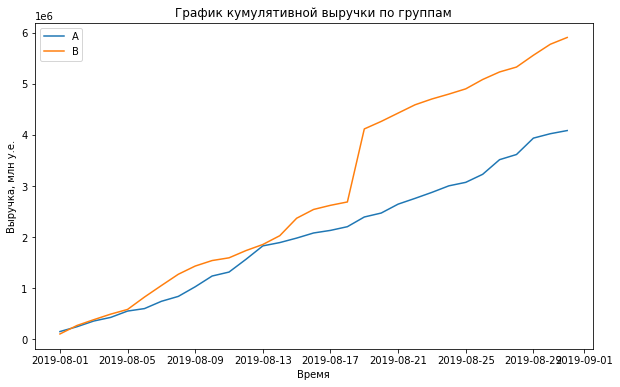

In [16]:
# кумулятивная выручка для группы A
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]

# кумулятивная выручка для группы B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

# построение графика
plt.figure(figsize=(10,6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Время')
plt.ylabel('Выручка, млн у.е.')
plt.legend()

plt.show()

По графику кумулятивной выручки видим, что в первые 17 дней теста значения выручки незначительно отличались друг от друга (но среднее значение по группе B было чуть выше). В середине теста произошел резкий рост по группе B, и группа продолжила лидировать до окончания теста. Возможно, туда закралась очень большая аномальная покупка, которая сильно завысила выручку в моменте - общий тренд после резкого скачка сохранился и не стал еще сильнее

**Кумулятивный график среднего чека**

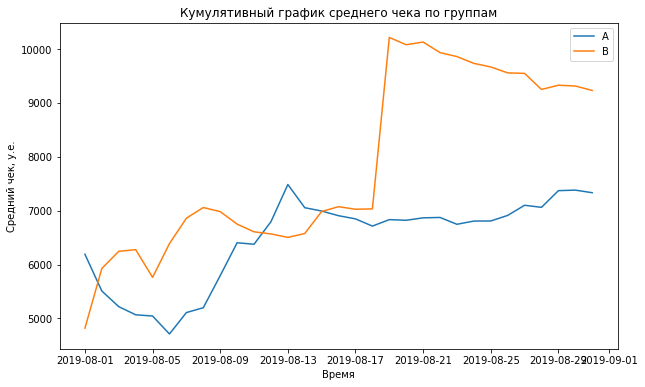

In [17]:
# построение кумулятивного графика среднего чека
plt.figure(figsize=(10,6))

plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')

plt.title('Кумулятивный график среднего чека по группам')
plt.xlabel('Время')
plt.ylabel('Средний чек, у.е.')
plt.legend() 

plt.show()

Аналогичный вывод и по значению среднего чека - в середине теста произошел резкий скачок по группе B, и причем в моменте. Предыдущий вывод подтверждается.

Затем не наблюдается один тренд на общий рост или снижение выручки в каждой группе - значения не стабилизировались.

**Построение графика относительного изменения кумулятивного среднего чека группы B к группе A**

Для построения графика относительного изменения кумулятивного среднего чека в одной группе к другой, получим новый датасет с отдельно вынесенными выручками и количеством заказов в каждой группе

In [18]:
# объединение значений кумулятивной выручки и количества заказов по группам A и B в один датасет
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on=['date'], 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B']
                                                  )

mergedCumulativeRevenue.head(10)

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101
5,2019-08-06,598401,127,824337,129
6,2019-08-07,740818,145,1049671,153
7,2019-08-08,837097,161,1270589,180
8,2019-08-09,1025603,177,1431401,205
9,2019-08-10,1236098,193,1539203,228


Новый датасет с отдельно вынесенными кумулятивными выручками и количеством заказов получили.

Теперь построим график относительного изменения кумулятивного среднего чека группы B относительно группы A.

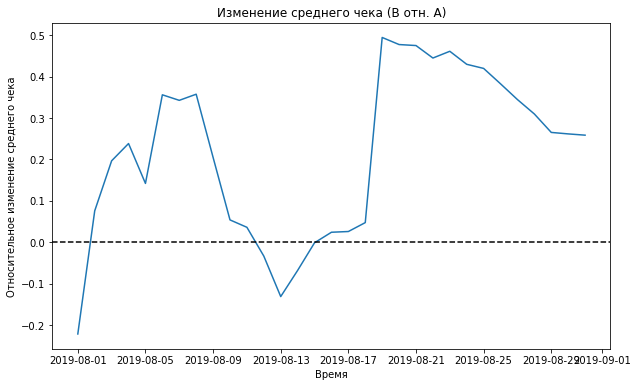

In [19]:
# построение графика относительного изменения кумулятивного среднего чека
plt.figure(figsize=(10,6))

plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB'])
         / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1
        )

plt.axhline(y=0, color='black', linestyle='--')

plt.title('Изменение среднего чека (B отн. A)')
plt.xlabel('Время')
plt.ylabel('Относительное изменение среднего чека')

plt.show()

Судя по относительнному различию в среднем чеке, в середине теста наблюдается период аномально невысоких по стоимости заказов. Но тем не менее, к концу теста кумулятивное значение среднего чека по группе B выше, чем по группе A. Возможно, именно в период середины теста происходили аномальные заказы (учитывая предыдущие выводы).

**Построение графика кумулятивной конверсии по группам**

Добавим новый столбец с расчетом конверсии в уже созданный датасет `cumulativeData`, затем заново выделим срезы по группам A и B.

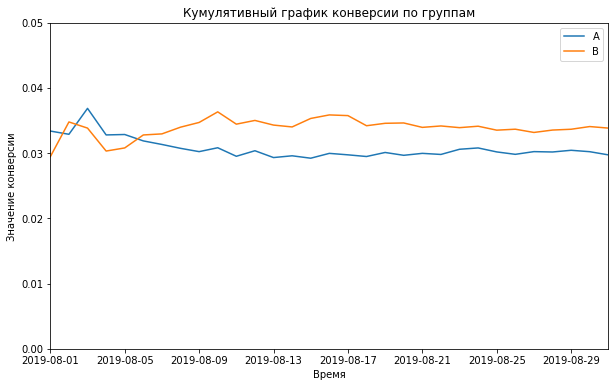

In [20]:
# расчет конверсии
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# выделение данных по группе A, с учетом данных по конверсии
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

# выделение данных по группе A, с учетом данных по конверсии
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

# построение графика
plt.figure(figsize=(10,6))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.xlabel('Время')
plt.ylabel('Значение конверсии')
plt.title('Кумулятивный график конверсии по группам')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])

plt.show()

В начале теста происходили небольшие колебания конверсий в обеих группах, но ближе к середине теста конверсии стабилизировались. Значение кумулятивной конверсии по группе B выросло примерно на 5%.

**График относительного изменения кумулятивной конверсии группы B к группе A**

In [21]:
# объединение значений кумулятивной конверсии по группам A и B в один датасет
mergedCumulativeConversions = (cumulativeDataA[['date', 'conversion']]
                               .merge(cumulativeDataB[['date', 'conversion']],
                                      left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
                              )

mergedCumulativeConversions.head(10)

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793
5,2019-08-06,0.031870,0.032783
6,2019-08-07,0.031324,0.032946
7,2019-08-08,0.030731,0.033975
8,2019-08-09,0.030225,0.034699
9,2019-08-10,0.030821,0.036323


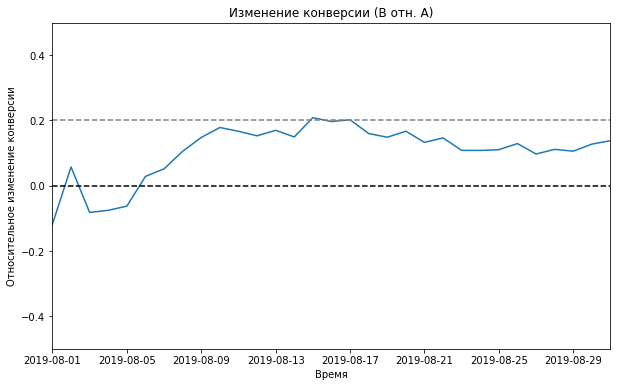

In [22]:
# построение графика относительного изменения конверсии в группе B 
plt.figure(figsize=(10,6))

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('Изменение конверсии (B отн. A)')
plt.xlabel('Время')
plt.ylabel('Относительное изменение конверсии')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.5, 0.5])

plt.show()

Действительно, группа B лидирует по значению конверсии почти с самого начала, весь тест не уступая группе A. На момент окончания теста улучшение конверсии по группе B относительно группы A составило примерно 15%.

#### Анализ аномалий и выбросов

На текущем шаге посмотрим на аномальные значения и выбросы по значениям выручки.

**Построение точечного графика количества заказов для каждого пользователя**

Для этого сгруппируем датасет `orders` по уникальным Id пользователей и посчитаем по каждому количество заказаов

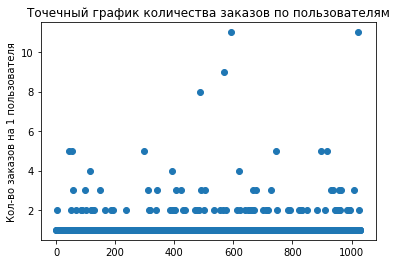

In [23]:
# получение данных по заказам на каждого пользователя
OrdersByUsers = (orders.groupby('visitorId', as_index=False)
                         .agg({'transactionId': 'nunique'})
                  )

# переименование столбцов
OrdersByUsers.columns = ['userId', 'orders']

# построение точечного графика по количествам заказов
x_values = pd.Series(range(0, len(OrdersByUsers)))
plt.scatter(x_values, OrdersByUsers['orders'])

plt.ylabel('Кол-во заказов на 1 пользователя')
plt.title('Точечный график количества заказов по пользователям')

plt.show()

Основная масса пользователей совершила от 1 до 3 заказов. Тем не менее, по 3 заказа совершено гораздо меньше, чем по 2. Стоит вопрос об определении "лимита", после которого количество заказов на 1 пользователя считать аномальным - для этого необходим расчет нескольких выборочных перцентилей.

**Расчет 95-го и 99-го перцентилей количества заказов на 1 пользователя**

In [24]:
# расчет 95 и 99 перцентилей кол-ва заказов на 1 пользователя
np.percentile(OrdersByUsers['orders'], [95, 99])

array([2., 4.])

95-й перцентиль равен 2. Это значит, что более 2 заказов совершили не более 5% пользователей. 99-й равен 4, то есть, только 1% пользователей совершили 4 заказа и более.

Но тем не менее, судя по графику, есть и большое количество пользователей с 3-мя заказами.

*Все что выше 99 перцентиля - считаем аномальным*

*Считаем 4 заказа на 1 пользователя как границу аномального количества заказов*

**Построение точечного графика стоимостей заказов**

Для построения графика нужны все значения выручки со всех заказов, из изначального датасета `orders`

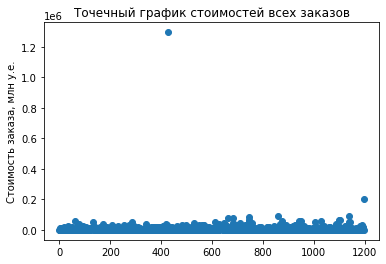

In [25]:
# построение точечного графика стоимостей всех заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.ylabel('Стоимость заказа, млн у.е.')
plt.title('Точечный график стоимостей всех заказов')

plt.show()

Исходя из графика, практически все заказы были в пределах 100-150 тыс. у.е.

Есть один аномальный заказ на сумму чуть больше 200 тыс. у.е., и еще один заказ почти на 1,2 млн у.е. Для точного определения границы стоимости аномальных заказов получим 95-й и 99-й перцентили.

Возможно, именно этот заказ на 1,2 млн у.е. резко завысил объем выручки и средний чек по группе B в середине теста, а также вызвал и резкое относительное увеличение чека, но на самом деле начал проявляться тренд на падение.

**Расчет 95-го и 99-го перцентилей стоимости 1 заказа**

In [26]:
# расчет 95 и 99 перцентилей стоимости заказов
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

95-й перцентиль равен 28 тыс. у.е. - это значит, что не более 5% пользователей совершили заказы дороже этой суммы. И не более 1% пользователей совершили заказы дороже 58,2 тыс. у.е.

*Все что выше 99 перцентиля - считаем аномальным*

*Считаем 58,2 тыс. у.е. как границу аномальной цены 1 заказа*

#### Расчеты статистической значимости

Проверим статистическую значимость по конверсии и среднему чеку.

В обоих случаях считаем значимость и по "сырым" данным, и по очищенным. Если убрать аномалии, разница может оказаться не статистически значимой, соответственно говорить о победе группы B будет некорректно.

Для проверки используем критерий Манна-Уитни, уровень значимости зададим 0.05 - общепринятое значение.

In [27]:
# задание уровня значимости
alpha = 0.05

Создадим один датасет `data` из всех "сырых данных" для дальнейших проверок

In [28]:
# создание нового датасета "сырых" данных

# количество пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# количество пользователей в выбранную дату в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# количество пользователей до выбранной даты включительно в группе B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# суммарная выручка и количество заказов в выбранную дату в группе A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# суммарная выручка до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# суммарная выручка и количество заказов в выбранную дату в группе B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# суммарная выручка до выбранной даты включительно в группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# получение целевого общего датасета
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# вывод полных данных
display(data.head(10))

# получение пользователей и числа совершенных заказов (если совершили хотя бы 1)
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935
6,2019-08-07,18,142417,24,225334,145,740818,153,1049671,644,709,4629,4644
7,2019-08-08,16,96279,27,220918,161,837097,180,1270589,610,654,5239,5298
8,2019-08-09,16,188506,25,160812,177,1025603,205,1431401,617,610,5856,5908
9,2019-08-10,16,210495,23,107802,193,1236098,228,1539203,406,369,6262,6277


**Также сразу найдем аномальных пользователей**

По итогам расчетов перцентилей, в список аномальных попадут те, кто совершил более 4-х заказов или совершил какой-либо из них на сумму более 52 833 у.е.

In [29]:
# получение id аномальных пользователей

# выделение пользователей по количеству заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)

# выделение пользователей по сумме совершенного заказа
usersWithExpensiveOrders = orders[orders['revenue'] > 52833]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# вывод id аномальных пользователей
abnormalUsers.head(10)

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
858     1316129916
425     1920142716
227     2038680547
1196    2108080724
287     2254456485
dtype: int64

Список id аномальных пользователей `abnormalUsers` получили. Используем его при расчете значимости на очищенных данных

##### Конверсия

Сформулируем нулевую и альтернативную гипотезы:
- **H0**: Вероятность получить равные конверсии в группах A и B случайна и статистически не значима.
- **H1**: Вероятность получить равные конверсии в группах A и B не случайна и статистически значима.

**Расчет статистической значимости различий в конверсии между группами по "сырым" данным**

In [30]:
# получение данных по числу заказов на каждого пользователя в группе A
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

# получение данных по числу заказов на каждого пользователя в группе B
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# получение выборки с количеством заказов по всем пользователям в группе A
# тем, кто ничего не заказывал - поставлены нули
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() \
                                                  - len(ordersByUsersA['orders'])), 
                               name='orders')],axis=0
                   )

# получение выборки с количеством заказов по всем пользователям в группе A
# тем, кто ничего не заказывал - поставлены нули
sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() \
                                                  - len(ordersByUsersB['orders'])),
                               name='orders')],axis=0
                   )

Теперь можем проверить гипотезу на "сырых данных"

In [31]:
# расчет p-value
p_value = st.mannwhitneyu(sampleA, sampleB)[1]

# проверка гипотезы о различиях в конверсии
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии выборок сделать нельзя")

p-значение:  0.016792355056752608
Отвергаем нулевую гипотезу: разница статистически значима


Между значениями конверсии в группах A и B есть значимые различия. По "сырым" данным - 1:0 в пользу группы B.

Посмотрим на сами значения конверсии.

In [32]:
print('Средее значение конверсии в группе A: {:.2%}'.format(sampleA.mean()))
print('Средее значение конверсии в группе B: {:.2%}'.format(sampleB.mean()))

Средее значение конверсии в группе A: 2.97%
Средее значение конверсии в группе B: 3.38%


Действительно, средняя конверсия в группе B отличается и довольно существено - на 0,4% в целом и примерно на 15% относительно.

**Расчет статистической значимости различий в конверсии между группами по "очищенным" данным**

Проверим гипотезу на "очищенных данных"

In [33]:
# получение очищенной выборки с количеством заказов по всем пользователям в группе A
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# получение очищенной выборки с количеством заказов по всем пользователям в группе B
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [34]:
# расчет p-value
p_value = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

# проверка гипотезы о различиях в конверсии на очищенных данных
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии выборок сделать нельзя")

p-значение:  0.012987550916817912
Отвергаем нулевую гипотезу: разница статистически значима


На "очищенных" данных ситуация не изменилась - отличия конверсий значимы. 2:0 в пользу группы B.

**Вывод по конверсии**

И в случае сырых, и в случае очищенных данных, отличия конверсии между выборками значимы. У группы B конверсия выше, добавление формы подписки на сайт оказалось эффективным с точки зрения привлечения пользователей.

##### Средний чек

Сформулируем нулевую и альтернативную гипотезы:
- H0: Средний чек в группе A равен среднему чеку в группе B
- H1: Средний чек в группе A не равен среднему чеку в группе B

Гипотеза двухсторонняя

Для проведения теста Манна-Уитни нужно 4 выборки:
- 1) 2 по выручке групп A и B из "сырых" данных
- 2) 2 по выручке групп A и B из "очищенных" данных

**Расчет статистической значимости различий в среднем чеке заказа между группами по "сырым" данным**

In [35]:
# получение выборок по группам A и B на сырых данных
sampleA_Revenue = orders[orders['group']=='A']['revenue']

sampleB_Revenue = orders[orders['group']=='B']['revenue']

In [36]:
# расчет p-value
p_value = st.mannwhitneyu(sampleA_Revenue, sampleB_Revenue)[1]

# проверка гипотезы о равенстве среднего чека на сырых данных
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии выборок сделать нельзя")

p-значение:  0.7292909855432458
Не получилось отвергнуть нулевую гипотезу: вывод о различии выборок сделать нельзя


Отличия на сырых данных незначимы - средний чек может быть равным в обеих группах с 73%-ой вероятностью.

**Расчет статистической значимости различий в среднем чеке заказа между группами по "очищенным" данным**

In [37]:
# получение очищенной выборки по среднему чеку в группе A
sampleA_Revenue_filtered = orders[
    np.logical_and(orders['group'] == 'A', 
                   np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

# получение очищенной выборки по среднему чеку в группе B
sampleB_Revenue_filtered = orders[
    np.logical_and(orders['group'] == 'B',
                   np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

In [38]:
# расчет p-value
p_value = st.mannwhitneyu(sampleA_Revenue_filtered, sampleB_Revenue_filtered)[1]

# проверка гипотезы о равенстве среднего чека на сырых данных
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии выборок сделать нельзя")

p-значение:  0.794416330141723
Не получилось отвергнуть нулевую гипотезу: вывод о различии выборок сделать нельзя


На "очищенных" данных ситуация не изменилась - отличия по-прежнему не значимы. Более того, вероятность случайно получить один и тот же средний чек немного выросла

**Вывод по среднему чеку**

И в случае сырых, и в случае очищенных данных, отличия среднего чека заказа между выборками не значимы.

Стоит посмотреть отдельно, вырос ли средний чек в принципе. Посмотрим по очищенным данным

In [39]:
print('Средний чек заказа в группе A:', sampleA_Revenue_filtered.mean())
print('Средний чек заказа в группе B:', sampleB_Revenue_filtered.mean())

Средний чек заказа в группе A: 6167.996197718631
Средний чек заказа в группе B: 6246.70684039088


По итогу, средний чек действительно вырос - но не настолько, чтобы отличия стали реально значимы.

Если добавить к этому выводу статистически значимый рост конверсии на 15% (относительный) - то будет расти общая выручка засчет привлечения большего числа новых пользователей

## Итоговый вывод

По итогам анализа A/B-теста, результаты можно считать промежуточными. По итогам, получены результаты:
- Имеется статистически значимое различие по конверсии между группами и в случае наличия аномалий, так и после их удаления
- Судя по относительному графику, конверсия в группе B стабильно выше, после роста зафиксировалась примерно на уровне 15%
- Отсутствует статистически значимое различие по значению среднего чека и при аномалий, и при их удалении. Тем не менее, в группе B он немного вырос
- График относительного изменения среднего чека колеблется - это объясняется наличием одного выброса по сумме заказа на 1,2 млн у.е.

**Стоит принять решение о продолжении теста и подтвердить статистическую значимость по среднему чеку**

Конверсия после внесения формы подписки на сайт стабильно лучше, в среднем чек с одного заказа немного вырос. Есть предпосылки для будущего признания этого теста полностью успешным. Даже если статистическая значимость достигнута не будет и средний чек почти не изменится, при статистически значимом росте конверсии получилось увеличить общую выручку (за счет большего количества новых заказов).

Но чтобы избежать проблемы подглядывания, в момент фиксации статистической значимости по среднему чеку, стоит подождать еще некоторое время (например, 7 дней) - все-таки средний чек может снова вырасти в моменте из-за какой-либо аномалии, а затем вернуться на прежний уровень.